In [1]:
# Imports
import numpy as np
import urllib.request
import pandas as pd 
import requests, zipfile, io
from datetime import datetime, timedelta, timezone
from zipfile import ZipFile
from bs4 import BeautifulSoup
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader

import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
# Read in NCEI data

## Creating a hail dataset
dir_url = 'https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles'
ext = '.csv.gz'

def listFD(url, ext=''):
    page = requests.get(url).text
    #print(file)
    soup = BeautifulSoup(page, 'html.parser')
    return [url + '/' + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]

# The years we want to analyze
year_list = [str(i) for i in range(2007,2023)]

li = []

for file in listFD(dir_url, ext):
    if any(year in file[:98] for year in year_list) & ('details' in file):
        print(file)
        df = pd.read_csv(file)#, compression = 'gzip'), #index_col=None, )
       
        hail_df = pd.DataFrame(df.loc[df['EVENT_TYPE'] == 'Tornado'])
        li.append(hail_df)
df_tor = pd.concat(li, axis=0, ignore_index=True)  

hail_datetimes = np.array([])

offset = [int(i.split('-')[1]) for i in df_tor['CZ_TIMEZONE']]


for i in range(0,len(df_tor['BEGIN_TIME'])):
    mtime        = str(np.array(df_tor['BEGIN_TIME'])[i])
    if len(mtime)<4:
        nz = 4 - len(mtime)
        nZ = '0'*nz
        mtime = nZ + mtime
    check_date = datetime(int(str(np.array(df_tor['BEGIN_YEARMONTH'])[i])[:4]), \
                     int(str(np.array(df_tor['BEGIN_YEARMONTH'])[i])[-2:]), \
                     int(str(np.array(df_tor['BEGIN_DAY'])[i])),           \
                     int(mtime[:-2]),     \
                     int(mtime[-2:])) + timedelta(hours = offset[i])
    hail_datetimes = np.append(hail_datetimes, check_date)

df_tor['Datetime'] = hail_datetimes
df_tor = df_tor.sort_values(by=['Datetime'], ignore_index = True)

ef_rating = df_tor['TOR_F_SCALE']
tor_lats  = df_tor['BEGIN_LAT']
tor_lons  = df_tor['BEGIN_LON']

https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2007_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2008_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2009_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2010_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2011_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2012_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2013_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2014_c20221018.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2015_

In [3]:
# for col in df_tor.columns:
#     print(col)

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [5]:
df_tor_drop = df_tor
df_tor_drop.drop(df_tor.index[df_tor['TOR_F_SCALE'] == 'EFU'], inplace=True)
df_tor_drop.reset_index(drop=True, inplace=True)

In [6]:
test=[]
for i in range(0, len(df_tor_drop.TOR_F_SCALE), 1):
    if len(df_tor_drop.TOR_F_SCALE[i])==3:
        temp = df_tor_drop.TOR_F_SCALE[i][2:]
    else: # Accounts for old F scale ratings
        temp = df_tor_drop.TOR_F_SCALE[i][1:]
    temp = int(temp)
    test.append(temp)

In [7]:
df_tor_drop['EF_Rate']=test

In [8]:
y = df_tor_drop.DEATHS_DIRECT.to_numpy()
x = df_tor_drop.EF_Rate.to_numpy()

x = x.reshape((-1, 1))

In [9]:
model = LinearRegression().fit(x,y)

In [10]:
r_sq = model.score(x,y)
r_sq

0.03005956066904114

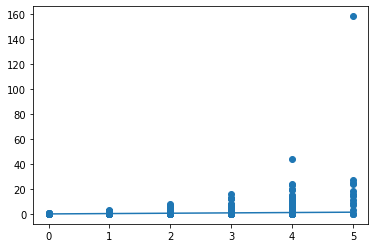

In [11]:
plt.scatter(x, y)
line_x = np.linspace(0, x.max(), 100)
line_y = line_x*model.coef_ + model.intercept_
plt.plot(line_x, line_y)

In [12]:
x_ = PolynomialFeatures(degree=3, include_bias=False).fit_transform(x)

In [13]:
model = LinearRegression().fit(x_, y)

In [14]:
r_sq = model.score(x_, y)
r_sq

0.1976139940321201

/Users/ecwolff3/opt/anaconda3/envs/py3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


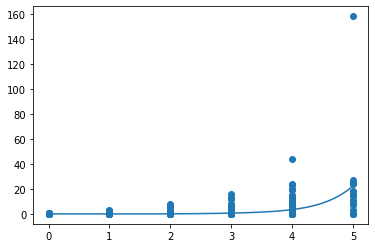

In [15]:
x = df_tor_drop.EF_Rate.to_numpy()

mymodel = np.poly1d(np.polyfit(x, y, 10))

myline = np.linspace(0, 5, 100)

plt.scatter(x, y)
plt.plot(myline, mymodel(myline))
plt.show()

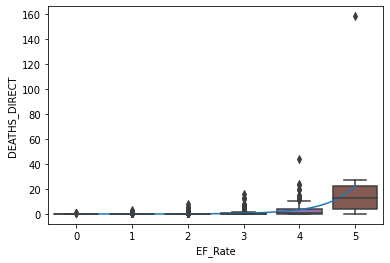

In [16]:
sns.boxplot(data=df_tor_drop, x="EF_Rate", y="DEATHS_DIRECT")
plt.plot(myline, mymodel(myline))
plt.show()

<AxesSubplot:xlabel='EF_Rate', ylabel='INJURIES_DIRECT'>

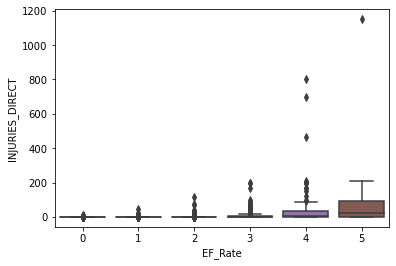

In [17]:
sns.boxplot(data=df_tor_drop, x="EF_Rate", y="INJURIES_DIRECT")

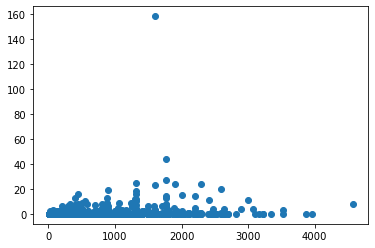

In [18]:
plt.scatter(df_tor_drop.TOR_WIDTH, df_tor_drop.DEATHS_DIRECT)

## CDC Data

In [19]:
df_tor_drop.CZ_FIPS

0         45
1         77
2         67
3        131
4        101
        ... 
21281    121
21282      5
21283    143
21284    145
21285     47
Name: CZ_FIPS, Length: 21286, dtype: int64

In [20]:
cdc = pd.read_csv('SVI2018_US_COUNTY.csv')

In [21]:
for col in cdc.columns:
    print(col)

ST
STATE
ST_ABBR
COUNTY
FIPS
LOCATION
AREA_SQMI
E_TOTPOP
M_TOTPOP
E_HU
M_HU
E_HH
M_HH
E_POV
M_POV
E_UNEMP
M_UNEMP
E_PCI
M_PCI
E_NOHSDP
M_NOHSDP
E_AGE65
M_AGE65
E_AGE17
M_AGE17
E_DISABL
M_DISABL
E_SNGPNT
M_SNGPNT
E_MINRTY
M_MINRTY
E_LIMENG
M_LIMENG
E_MUNIT
M_MUNIT
E_MOBILE
M_MOBILE
E_CROWD
M_CROWD
E_NOVEH
M_NOVEH
E_GROUPQ
M_GROUPQ
EP_POV
MP_POV
EP_UNEMP
MP_UNEMP
EP_PCI
MP_PCI
EP_NOHSDP
MP_NOHSDP
EP_AGE65
MP_AGE65
EP_AGE17
MP_AGE17
EP_DISABL
MP_DISABL
EP_SNGPNT
MP_SNGPNT
EP_MINRTY
MP_MINRTY
EP_LIMENG
MP_LIMENG
EP_MUNIT
MP_MUNIT
EP_MOBILE
MP_MOBILE
EP_CROWD
MP_CROWD
EP_NOVEH
MP_NOVEH
EP_GROUPQ
MP_GROUPQ
EPL_POV
EPL_UNEMP
EPL_PCI
EPL_NOHSDP
SPL_THEME1
RPL_THEME1
EPL_AGE65
EPL_AGE17
EPL_DISABL
EPL_SNGPNT
SPL_THEME2
RPL_THEME2
EPL_MINRTY
EPL_LIMENG
SPL_THEME3
RPL_THEME3
EPL_MUNIT
EPL_MOBILE
EPL_CROWD
EPL_NOVEH
EPL_GROUPQ
SPL_THEME4
RPL_THEME4
SPL_THEMES
RPL_THEMES
F_POV
F_UNEMP
F_PCI
F_NOHSDP
F_THEME1
F_AGE65
F_AGE17
F_DISABL
F_SNGPNT
F_THEME2
F_MINRTY
F_LIMENG
F_THEME3
F_MUNIT
F_MOBILE
F_CR

In [22]:
cdc_trim = cdc[['FIPS', 'SPL_THEMES']].copy()

In [23]:
cdc_trim

,FIPS,SPL_THEMES
0,35039,-999.0000
1,1001,7.0688
2,1009,7.0137
3,1013,9.7579
4,1015,9.4046
...,...,...
3137,48131,12.4228
3138,48505,11.5737
3139,48507,12.2952
3140,48127,12.4890


In [24]:
# Create full FIPS

test1 = []
for i in range(0, len(df_tor_drop.CZ_FIPS), 1):
    val1 = str(df_tor_drop.CZ_FIPS[i])
    val2 = str(df_tor_drop.STATE_FIPS[i])
    if df_tor_drop.CZ_FIPS[i]<100:
        temp1 = val2+'0'+val1
        temp2 = int(temp1)
    else:
        temp1 = val2+val1
        temp2 = int(temp1)
    test1.append(temp2)
test1

[22045,
 22077,
 28067,
 28131,
 28101,
 28099,
 28099,
 28099,
 28069,
 28103,
 13077,
 13077,
 45077,
 45083,
 37071,
 13299,
 1123,
 13077,
 1045,
 105,
 48027,
 48209,
 12119,
 12069,
 12069,
 12127,
 12127,
 12105,
 22055,
 22099,
 22045,
 22113,
 22051,
 22071,
 22071,
 28129,
 28065,
 28109,
 28059,
 12077,
 45065,
 45037,
 1065,
 1105,
 1125,
 107,
 13251,
 107,
 4505,
 101,
 4509,
 48179,
 20119,
 20119,
 20057,
 22015,
 20167,
 5139,
 5011,
 5043,
 5043,
 5079,
 5041,
 22111,
 5139,
 5043,
 5079,
 5041,
 501,
 5043,
 503,
 29101,
 28133,
 28083,
 22025,
 22029,
 22025,
 22029,
 28121,
 28101,
 6067,
 12011,
 20207,
 2003,
 2001,
 2003,
 2001,
 2003,
 20107,
 29013,
 29037,
 29101,
 29137,
 29137,
 29137,
 29205,
 5015,
 29153,
 29091,
 22025,
 17181,
 12113,
 28163,
 1013,
 1131,
 1047,
 17115,
 1031,
 1045,
 1067,
 21219,
 13061,
 13239,
 1085,
 1101,
 1057,
 1125,
 13259,
 1133,
 1043,
 1073,
 13269,
 13079,
 13021,
 13079,
 13021,
 1081,
 1113,
 13169,
 13215,
 13169,
 111

In [25]:
df_tor_fips = df_tor_drop
df_tor_fips['FIPS'] = test1

In [26]:
df_cdc = pd.merge(df_tor_fips, cdc_trim, how="left", on=["FIPS"])

In [27]:
df_cdc

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,Datetime,EF_Rate,FIPS,SPL_THEMES
0,200701,4,1545,200701,4,1552,2664,13767,LOUISIANA,22,...,-91.7980,30.0500,-91.7300,As a low pressure system in the northwest Gulf...,A tornado struck at 3:45 pm near the town of L...,CSV,2007-01-04 21:45:00,1,22045,10.8631
1,200701,4,1635,200701,4,1640,2442,12265,LOUISIANA,22,...,-91.4500,30.6200,-91.4700,An area of low pressure and an associated warm...,"A tornado demolished one home, took the roofs ...",CSV,2007-01-04 22:35:00,1,22077,9.6017
2,200701,5,27,200701,5,29,1418,6920,MISSISSIPPI,28,...,-89.2940,31.7366,-89.2765,During the evening of Jan 4th and early mornin...,This brief tornado snapped and uprooted numero...,CSV,2007-01-05 06:27:00,1,28067,10.0277
3,200701,5,40,200701,5,42,2543,12831,MISSISSIPPI,28,...,-89.1300,30.8500,-89.1300,A weak tornado developed during the early morn...,A weak tornado first touched down near the fir...,CSV,2007-01-05 06:40:00,0,28131,8.0471
4,200701,5,57,200701,5,101,1418,6925,MISSISSIPPI,28,...,-89.2700,32.5756,-89.2397,During the evening of Jan 4th and early mornin...,This tornado touched down in northwest Newton ...,CSV,2007-01-05 06:57:00,1,28101,10.3275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21281,202207,28,940,202207,28,955,172344,1046201,NEW YORK,36,...,-78.3300,42.6500,-78.1400,A tornado touched down in Wyoming County at ap...,A tornado touched down in Wyoming County at ap...,CSV,2022-07-28 14:40:00,2,36121,6.3361
21282,202207,28,1735,202207,28,1745,172129,1044937,CONNECTICUT,9,...,-73.2078,41.9651,-73.1194,A thunderstorm developed across northwestern C...,An EF-0 tornado touched down about 2 miles sou...,CSV,2022-07-28 22:35:00,0,905,NaN
21283,202207,28,2135,202207,28,2137,170571,1034542,OKLAHOMA,40,...,-95.7790,36.0588,-95.7617,Scattered strong to severe thunderstorms devel...,This is the first segment of a two segment tor...,CSV,2022-07-29 03:35:00,1,40143,8.1063
21284,202207,28,2137,202207,28,2144,170571,1034543,OKLAHOMA,40,...,-95.7617,36.0700,-95.7100,Scattered strong to severe thunderstorms devel...,This is the second segment of a two segment to...,CSV,2022-07-29 03:37:00,1,40145,7.0138


In [28]:
#df_cdc_drop = df_cdc.dropna(axis=0)
df_cdc_drop = df_cdc[df_cdc['SPL_THEMES'].notna()]
df_cdc_drop = df_cdc_drop[df_cdc_drop['SPL_THEMES']!=-999.0]

In [29]:
y = df_cdc_drop.DEATHS_DIRECT.to_numpy()
x = df_cdc_drop.SPL_THEMES.to_numpy()

x = x.reshape((-1, 1))

In [30]:
model = LinearRegression().fit(x,y)

In [31]:
r_sq = model.score(x,y)
r_sq

0.00021478078206593754

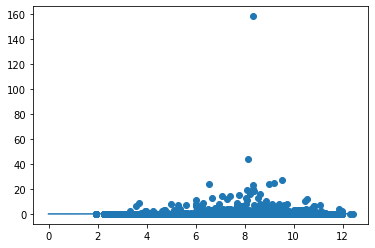

In [32]:
plt.scatter(x, y)
line_x = np.linspace(0, x.max(), 100)
line_y = line_x*model.coef_ + model.intercept_
plt.plot(line_x, line_y)

In [33]:
cdc_trim = cdc[['FIPS', 'RPL_THEMES']].copy()

In [34]:
df_cdc = pd.merge(df_tor_fips, cdc_trim, how="left", on=["FIPS"])

In [35]:
#df_cdc_drop = df_cdc.dropna(axis=0)
df_cdc_drop = df_cdc[df_cdc['RPL_THEMES'].notna()]
df_cdc_drop = df_cdc_drop[df_cdc_drop['RPL_THEMES']!=-999.0]

In [36]:
y = df_cdc_drop.DEATHS_DIRECT.to_numpy()
x = df_cdc_drop.RPL_THEMES.to_numpy()

x = x.reshape((-1, 1))

In [37]:
model = LinearRegression().fit(x,y)

In [38]:
r_sq = model.score(x,y)
r_sq

0.00026232847325313724

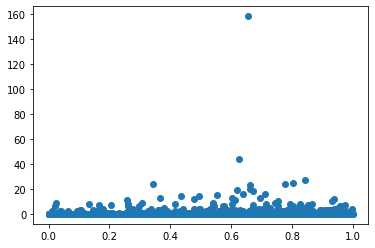

In [39]:
plt.scatter(x, y)
line_x = np.linspace(0, x.max(), 100)
line_y = line_x*model.coef_ + model.intercept_
plt.plot(line_x, line_y)

In [40]:
# Idea: somehow normalize for tornado strength

In [41]:
idea1 = df_cdc_drop[df_cdc_drop['EF_Rate']==4]

In [42]:
y = idea1.DEATHS_DIRECT.to_numpy()
x = idea1.RPL_THEMES.to_numpy()

x = x.reshape((-1, 1))

In [43]:
model = LinearRegression().fit(x,y)

In [44]:
r_sq = model.score(x,y)
r_sq

0.03426004935222571

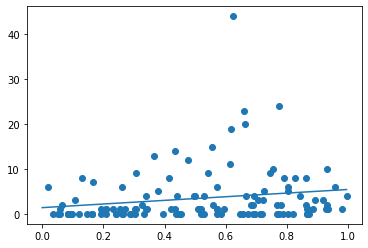

In [45]:
plt.scatter(x, y)
line_x = np.linspace(0, x.max(), 100)
line_y = line_x*model.coef_ + model.intercept_
plt.plot(line_x, line_y)

In [46]:
idea2 = df_cdc_drop[df_cdc_drop['DEATHS_DIRECT']>=5]
idea2 = idea2[idea2['EF_Rate']==4]

In [47]:
y = idea2.DEATHS_DIRECT.to_numpy()
x = idea2.RPL_THEMES.to_numpy()

x = x.reshape((-1, 1))

In [48]:
model = LinearRegression().fit(x,y)

In [49]:
r_sq = model.score(x,y)
r_sq

0.013177259366450422

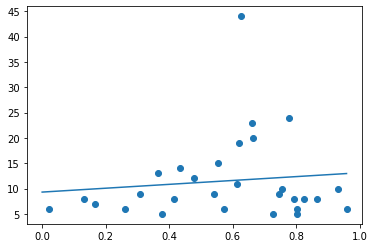

In [50]:
plt.scatter(x, y)
line_x = np.linspace(0, x.max(), 100)
line_y = line_x*model.coef_ + model.intercept_
plt.plot(line_x, line_y)

In [51]:
full_cdc = pd.merge(df_tor_fips, cdc, how="left", on=["FIPS"])

In [52]:
full_cdc

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE_x,STATE_FIPS,...,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP
0,200701,4,1545,200701,4,1552,2664,13767,LOUISIANA,22,...,0.0,1.0,0.0,1.0,3.0,8365.0,780.0,11.6,1.1,67630.0
1,200701,4,1635,200701,4,1640,2442,12265,LOUISIANA,22,...,1.0,0.0,0.0,1.0,2.0,2781.0,432.0,12.6,2.0,17365.0
2,200701,5,27,200701,5,29,1418,6920,MISSISSIPPI,28,...,0.0,0.0,0.0,0.0,1.0,7237.0,722.0,10.7,1.1,70178.0
3,200701,5,40,200701,5,42,2543,12831,MISSISSIPPI,28,...,1.0,0.0,0.0,1.0,1.0,2376.0,455.0,13.4,2.5,17962.0
4,200701,5,57,200701,5,101,1418,6925,MISSISSIPPI,28,...,1.0,0.0,0.0,1.0,3.0,2427.0,415.0,11.4,1.9,18638.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21281,202207,28,940,202207,28,955,172344,1046201,NEW YORK,36,...,0.0,0.0,0.0,0.0,0.0,1576.0,225.0,4.2,0.6,34806.0
21282,202207,28,1735,202207,28,1745,172129,1044937,CONNECTICUT,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21283,202207,28,2135,202207,28,2137,170571,1034542,OKLAHOMA,40,...,0.0,0.0,0.0,1.0,1.0,89576.0,1631.0,14.0,0.3,636846.0
21284,202207,28,2137,202207,28,2144,170571,1034543,OKLAHOMA,40,...,0.0,0.0,0.0,0.0,0.0,8863.0,505.0,11.4,0.7,46808.0


In [53]:
#df_cdc_drop = df_cdc.dropna(axis=0)
full_cdc_drop = full_cdc[full_cdc['SPL_THEMES'].notna()]
full_cdc_drop = full_cdc_drop[full_cdc_drop['SPL_THEMES']!=-999.0]

In [54]:
for col in full_cdc_drop.columns:
    print(col)

BEGIN_YEARMONTH
BEGIN_DAY
BEGIN_TIME
END_YEARMONTH
END_DAY
END_TIME
EPISODE_ID
EVENT_ID
STATE_x
STATE_FIPS
YEAR
MONTH_NAME
EVENT_TYPE
CZ_TYPE
CZ_FIPS
CZ_NAME
WFO
BEGIN_DATE_TIME
CZ_TIMEZONE
END_DATE_TIME
INJURIES_DIRECT
INJURIES_INDIRECT
DEATHS_DIRECT
DEATHS_INDIRECT
DAMAGE_PROPERTY
DAMAGE_CROPS
SOURCE
MAGNITUDE
MAGNITUDE_TYPE
FLOOD_CAUSE
CATEGORY
TOR_F_SCALE
TOR_LENGTH
TOR_WIDTH
TOR_OTHER_WFO
TOR_OTHER_CZ_STATE
TOR_OTHER_CZ_FIPS
TOR_OTHER_CZ_NAME
BEGIN_RANGE
BEGIN_AZIMUTH
BEGIN_LOCATION
END_RANGE
END_AZIMUTH
END_LOCATION
BEGIN_LAT
BEGIN_LON
END_LAT
END_LON
EPISODE_NARRATIVE
EVENT_NARRATIVE
DATA_SOURCE
Datetime
EF_Rate
FIPS
ST
STATE_y
ST_ABBR
COUNTY
LOCATION
AREA_SQMI
E_TOTPOP
M_TOTPOP
E_HU
M_HU
E_HH
M_HH
E_POV
M_POV
E_UNEMP
M_UNEMP
E_PCI
M_PCI
E_NOHSDP
M_NOHSDP
E_AGE65
M_AGE65
E_AGE17
M_AGE17
E_DISABL
M_DISABL
E_SNGPNT
M_SNGPNT
E_MINRTY
M_MINRTY
E_LIMENG
M_LIMENG
E_MUNIT
M_MUNIT
E_MOBILE
M_MOBILE
E_CROWD
M_CROWD
E_NOVEH
M_NOVEH
E_GROUPQ
M_GROUPQ
EP_POV
MP_POV
EP_UNEMP
MP_UNEMP
EP_PCI


In [55]:
#df_cdc_drop = df_cdc.dropna(axis=0)
full_cdc_drop_temp = full_cdc_drop[full_cdc_drop['EP_MOBILE'].notna()]
full_cdc_drop_temp = full_cdc_drop_temp[full_cdc_drop_temp['EP_MOBILE']!=-999.0]

In [56]:
idea3 = full_cdc_drop_temp[full_cdc_drop_temp['DEATHS_DIRECT']>=5]
idea3 = idea3[idea3['EF_Rate']>=4]

In [57]:
y = idea3.DEATHS_DIRECT.to_numpy()
x = idea3.EP_MOBILE.to_numpy()

x = x.reshape((-1, 1))

In [58]:
model = LinearRegression().fit(x,y)

In [59]:
r_sq = model.score(x,y)
r_sq

0.03472923536130734

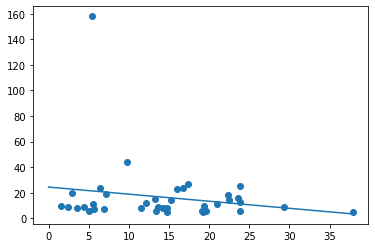

In [60]:
plt.scatter(x, y)
line_x = np.linspace(0, x.max(), 100)
line_y = line_x*model.coef_ + model.intercept_
plt.plot(line_x, line_y)

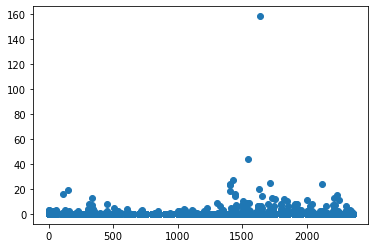

In [61]:
idea4 = full_cdc_drop_temp
plt.scatter(idea4.BEGIN_TIME, idea4.DEATHS_DIRECT)

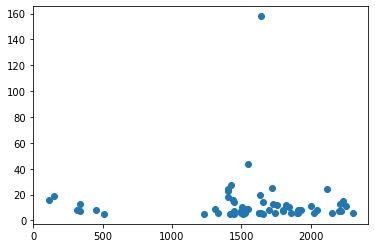

In [62]:
idea4 = full_cdc_drop_temp[full_cdc_drop_temp['DEATHS_DIRECT']>=5]
plt.scatter(idea4.BEGIN_TIME, idea4.DEATHS_DIRECT)

In [63]:
idea5 = full_cdc[(full_cdc['BEGIN_TIME']<=600) | (full_cdc['BEGIN_TIME']>=2200)]

In [64]:
idea5_2 = idea5[idea5['DEATHS_DIRECT']>=1]

In [65]:
idea5_3 = full_cdc[full_cdc['DEATHS_DIRECT']>=1]

In [66]:
p_all = len(idea5)/len(full_cdc)
p_all

0.14897115474960068

In [67]:
p_fatal = len(idea5_2)/len(idea5_3)
p_fatal

0.2413793103448276

In [68]:
idea5_4 = idea5[idea5['EF_Rate']>=3]

idea5_5 = full_cdc[full_cdc['EF_Rate']>=3]

In [69]:
p_strong = len(idea5_4)/len(idea5_5)
p_strong

0.150354609929078

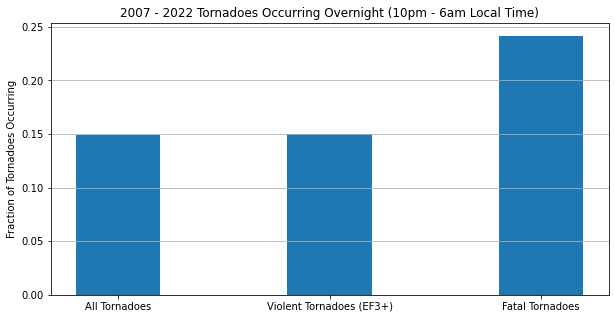

In [70]:
# creating the dataset
data = {'All Tornadoes':p_all, 'Violent Tornadoes (EF3+)':p_strong, 
        'Fatal Tornadoes':p_fatal}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values,
        width = 0.4)
 
#plt.xlabel("Category")
plt.ylabel("Fraction of Tornadoes Occurring")
plt.title("2007 - 2022 Tornadoes Occurring Overnight (10pm - 6am Local Time)")
plt.grid(axis='y')
plt.show()

Repeat with just the SE

In [356]:
drop_indices = []
for i in range(0, len(full_cdc.STATE_x), 1):
    if (full_cdc.STATE_x[i] == 'GEORGIA') or (full_cdc.STATE_x[i] == 'ALABAMA') or\
       (full_cdc.STATE_x[i] == 'MISSISSIPPI') or (full_cdc.STATE_x[i] == 'ARKANSAS') or\
       (full_cdc.STATE_x[i] == 'TENNESSEE') or (full_cdc.STATE_x[i] == 'LOUISIANA'):
        continue
    else:
        drop_indices.append(i)

In [357]:
SE_full = full_cdc.drop(labels=drop_indices, axis=0)
SE_full

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE_x,STATE_FIPS,...,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP,Cool
0,200701,4,1545,200701,4,1552,2664,13767,LOUISIANA,22,...,1.0,0.0,1.0,3.0,8365.0,780.0,11.6,1.1,67630.0,1
1,200701,4,1635,200701,4,1640,2442,12265,LOUISIANA,22,...,0.0,0.0,1.0,2.0,2781.0,432.0,12.6,2.0,17365.0,1
2,200701,5,27,200701,5,29,1418,6920,MISSISSIPPI,28,...,0.0,0.0,0.0,1.0,7237.0,722.0,10.7,1.1,70178.0,1
3,200701,5,40,200701,5,42,2543,12831,MISSISSIPPI,28,...,0.0,0.0,1.0,1.0,2376.0,455.0,13.4,2.5,17962.0,1
4,200701,5,57,200701,5,101,1418,6925,MISSISSIPPI,28,...,0.0,0.0,1.0,3.0,2427.0,415.0,11.4,1.9,18638.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21060,202205,25,1216,202205,25,1220,169840,1029067,MISSISSIPPI,28,...,0.0,0.0,1.0,4.0,3469.0,398.0,12.0,1.4,27282.0,0
21064,202205,26,1225,202205,26,1229,168139,1025853,ALABAMA,1,...,0.0,0.0,0.0,0.0,11937.0,1053.0,10.2,0.9,110465.0,0
21137,202206,6,1743,202206,6,1746,170915,1037255,TENNESSEE,47,...,1.0,0.0,1.0,2.0,1799.0,272.0,10.3,1.6,14152.0,0
21232,202206,26,1829,202206,26,1836,169173,1025491,MISSISSIPPI,28,...,0.0,0.0,1.0,1.0,4441.0,681.0,13.1,2.0,31308.0,0


In [359]:
new_idea5 = SE_full[(SE_full['BEGIN_TIME']<=600) | (SE_full['BEGIN_TIME']>=2200)]

In [360]:
new_idea5_2 = new_idea5[new_idea5['DEATHS_DIRECT']>=1]

In [361]:
new_idea5_3 = SE_full[SE_full['DEATHS_DIRECT']>=1]

In [362]:
p_all = len(new_idea5)/len(SE_full)
p_all

0.2395870416518334

In [363]:
p_fatal = len(new_idea5_2)/len(new_idea5_3)
p_fatal

0.2994652406417112

In [364]:
new_idea5_4 = new_idea5[new_idea5['EF_Rate']>=3]

new_idea5_5 = SE_full[SE_full['EF_Rate']>=3]

In [366]:
p_strong = len(new_idea5_4)/len(new_idea5_5)
p_strong

0.20357142857142857

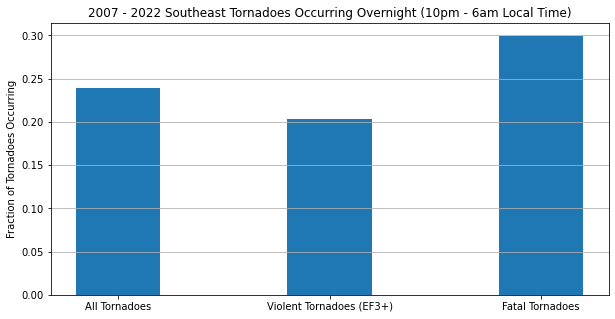

In [368]:
# creating the dataset
data = {'All Tornadoes':p_all, 'Violent Tornadoes (EF3+)':p_strong, 
        'Fatal Tornadoes':p_fatal}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values,
        width = 0.4)
 
#plt.xlabel("Category")
plt.ylabel("Fraction of Tornadoes Occurring")
plt.title("2007 - 2022 Southeast Tornadoes Occurring Overnight (10pm - 6am Local Time)")
plt.grid(axis='y')
plt.show()

Just MS

In [497]:
state = 'ILLINOIS'
drop_indices = []
for i in range(0, len(full_cdc.STATE_x), 1):
    if (full_cdc.STATE_x[i] == state):
        continue
    else:
        drop_indices.append(i)

In [498]:
MS_full = full_cdc.drop(labels=drop_indices, axis=0)
MS_full

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE_x,STATE_FIPS,...,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP,Cool
100,200703,1,1045,200703,1,1047,2048,10085,ILLINOIS,17,...,0.0,0.0,0.0,0.0,970.0,198.0,5.7,1.2,14737.0,0
106,200703,1,1247,200703,1,1248,2954,15495,ILLINOIS,17,...,0.0,0.0,0.0,0.0,5067.0,627.0,4.9,0.6,109733.0,0
201,200703,28,1405,200703,28,1405,3407,18577,ILLINOIS,17,...,0.0,1.0,1.0,1.0,1306.0,250.0,5.0,1.0,26642.0,0
202,200703,28,1419,200703,28,1419,3407,18578,ILLINOIS,17,...,0.0,0.0,1.0,1.0,6516.0,677.0,3.8,0.4,172303.0,0
465,200704,25,1340,200704,25,1340,3638,20093,ILLINOIS,17,...,0.0,0.0,0.0,0.0,1541.0,299.0,4.9,1.0,28670.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21212,202206,17,536,202206,17,544,170150,1035610,ILLINOIS,17,...,0.0,0.0,0.0,0.0,703.0,183.0,4.5,1.2,14446.0,0
21271,202207,23,440,202207,23,441,170430,1041750,ILLINOIS,17,...,0.0,0.0,1.0,1.0,54274.0,2612.0,5.9,0.3,1004961.0,0
21272,202207,23,441,202207,23,446,170430,1041752,ILLINOIS,17,...,0.0,0.0,0.0,0.0,38219.0,1921.0,5.6,0.3,562135.0,0
21273,202207,23,452,202207,23,458,170430,1041749,ILLINOIS,17,...,0.0,0.0,0.0,0.0,38219.0,1921.0,5.6,0.3,562135.0,0


In [499]:
new_idea5 = MS_full[(MS_full['BEGIN_TIME']<=600) | (MS_full['BEGIN_TIME']>=2000)]

In [500]:
new_idea5_2 = new_idea5[new_idea5['DEATHS_DIRECT']>=1]

In [501]:
new_idea5_3 = MS_full[MS_full['DEATHS_DIRECT']>=1]

In [502]:
p_all = len(new_idea5)/len(MS_full)
p_all

0.2066974595842956

In [503]:
p_fatal = len(new_idea5_2)/len(new_idea5_3)
p_fatal

0.4

In [504]:
new_idea5_4 = new_idea5[new_idea5['EF_Rate']>=3]

new_idea5_5 = MS_full[MS_full['EF_Rate']>=3]

In [505]:
p_strong = len(new_idea5_4)/len(new_idea5_5)
p_strong

0.3448275862068966

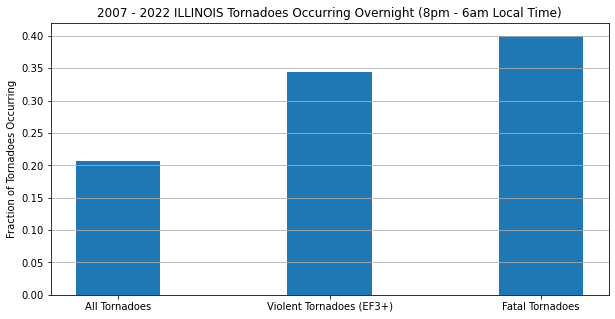

In [506]:
# creating the dataset
data = {'All Tornadoes':p_all, 'Violent Tornadoes (EF3+)':p_strong, 
        'Fatal Tornadoes':p_fatal}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values,
        width = 0.4)
 
#plt.xlabel("Category")
plt.ylabel("Fraction of Tornadoes Occurring")
plt.title(f"2007 - 2022 {state} Tornadoes Occurring Overnight (8pm - 6am Local Time)")
plt.grid(axis='y')
plt.show()

In [71]:
full_cdc_a = full_cdc[full_cdc['EP_MOBILE'].notna()]
full_cdc_a = full_cdc_a[full_cdc_a['EP_MOBILE']!=-999.0]

In [72]:
idea6 = full_cdc_a[full_cdc_a['EP_MOBILE']>=20]

In [73]:
idea6_2 = idea6[idea6['DEATHS_DIRECT']>=1]

idea6_3 = full_cdc_a[full_cdc_a['DEATHS_DIRECT']>=1]

In [74]:
p_in = len(idea6)/len(full_cdc_a)
p_in

0.22268928589300907

In [75]:
p_fatal_mobile = len(idea6_2)/len(idea6_3)
p_fatal_mobile

0.3008356545961003

In [76]:
idea6_4 = idea6[idea6['EF_Rate']>=3]

idea6_5 = full_cdc_a[full_cdc_a['EF_Rate']>=3]

In [77]:
p_strong_mobile = len(idea6_4)/len(idea6_5)
p_strong_mobile

0.2563338301043219

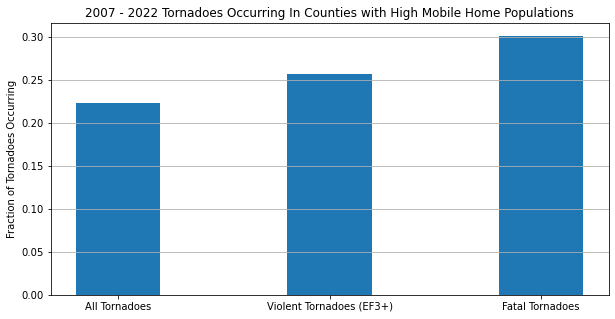

In [78]:
# creating the dataset
data = {'All Tornadoes':p_in, 'Violent Tornadoes (EF3+)':p_strong_mobile, 
        'Fatal Tornadoes':p_fatal_mobile}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values,
        width = 0.4)
 
#plt.xlabel("Category")
plt.ylabel("Fraction of Tornadoes Occurring")
plt.title("2007 - 2022 Tornadoes Occurring In Counties with High Mobile Home Populations")
plt.grid(axis='y')
plt.show()

In [345]:
full_cdc_a = full_cdc[full_cdc['RPL_THEMES'].notna()]
full_cdc_a = full_cdc_a[full_cdc_a['RPL_THEMES']!=-999.0]

In [346]:
idea7 = full_cdc_a[full_cdc_a['RPL_THEMES']>=0.6]
#idea7 = full_cdc_a[full_cdc_a['RPL_THEMES']>=0.75]

In [347]:
idea7_2 = idea7[idea7['DEATHS_DIRECT']>=1]

idea7_3 = full_cdc_a[full_cdc_a['DEATHS_DIRECT']>=1]

In [575]:
len(full_cdc[full_cdc['DEATHS_DIRECT']>=1])

377

In [348]:
p_RPL = len(idea7)/len(full_cdc_a)
p_RPL

0.432939645681113

In [349]:
p_fatal_RPL = len(idea7_2)/len(idea7_3)
p_fatal_RPL

0.5515320334261838

In [350]:
idea7_4 = idea7[idea7['EF_Rate']>=3]

idea7_5 = full_cdc_a[full_cdc_a['EF_Rate']>=3]

In [351]:
p_strong_RPL = len(idea7_4)/len(idea7_5)
p_strong_RPL

0.4918032786885246

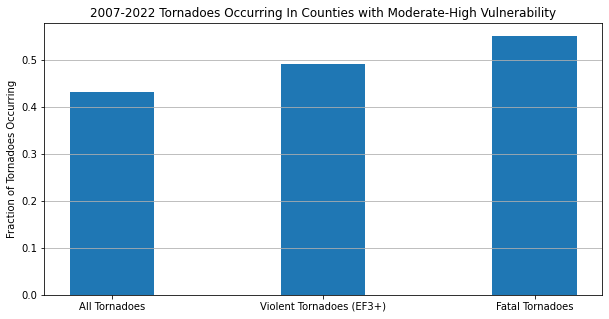

In [354]:
# creating the dataset
data = {'All Tornadoes':p_RPL, 'Violent Tornadoes (EF3+)':p_strong_RPL, 
        'Fatal Tornadoes':p_fatal_RPL}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values,
        width = 0.4)
 
#plt.xlabel("Category")
plt.ylabel("Fraction of Tornadoes Occurring")
plt.title("2007-2022 Tornadoes Occurring In Counties with Moderate-High Vulnerability")
plt.grid(axis='y')
plt.show()

In [87]:
full_cdc_a = full_cdc[full_cdc['EP_MINRTY'].notna()]
full_cdc_a = full_cdc_a[full_cdc_a['EP_MINRTY']!=-999.0]

In [88]:
idea8 = full_cdc_a[full_cdc_a['EP_MINRTY']>=70]

In [89]:
idea8_2 = idea8[idea8['DEATHS_DIRECT']>=1]

idea8_3 = full_cdc_a[full_cdc_a['DEATHS_DIRECT']>=1]

In [90]:
p_Min = len(idea8)/len(full_cdc_a)
p_Min

0.03207726567582445

In [91]:
p_fatal_Min = len(idea8_2)/len(idea8_3)
p_fatal_Min

0.033426183844011144

In [92]:
idea8_4 = idea8[idea8['EF_Rate']>=3]

idea8_5 = full_cdc_a[full_cdc_a['EF_Rate']>=3]

In [93]:
p_strong_Min = len(idea8_4)/len(idea8_5)
p_strong_Min

0.03129657228017884

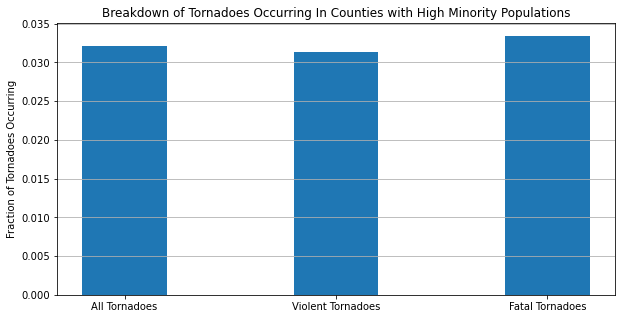

In [94]:
# creating the dataset
data = {'All Tornadoes':p_Min, 'Violent Tornadoes':p_strong_Min, 
        'Fatal Tornadoes':p_fatal_Min}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values,
        width = 0.4)
 
#plt.xlabel("Category")
plt.ylabel("Fraction of Tornadoes Occurring")
plt.title("Breakdown of Tornadoes Occurring In Counties with High Minority Populations")
plt.grid(axis='y')
plt.show()

In [95]:
full_cdc_a = full_cdc[full_cdc['EP_LIMENG'].notna()]
full_cdc_a = full_cdc_a[full_cdc_a['EP_LIMENG']!=-999.0]

In [96]:
idea9 = full_cdc_a[full_cdc_a['EP_LIMENG']>=5]

In [97]:
idea9_2 = idea9[idea9['DEATHS_DIRECT']>=1]

idea9_3 = full_cdc_a[full_cdc_a['DEATHS_DIRECT']>=1]

In [98]:
p_En = len(idea9)/len(full_cdc_a)
p_En

0.07261171996196768

In [99]:
p_fatal_En = len(idea9_2)/len(idea9_3)
p_fatal_En

0.027855153203342618

In [100]:
idea9_4 = idea9[idea9['EF_Rate']>=3]

idea9_5 = full_cdc_a[full_cdc_a['EF_Rate']>=3]

In [101]:
p_strong_En = len(idea9_4)/len(idea9_5)
p_strong_En

0.046199701937406856

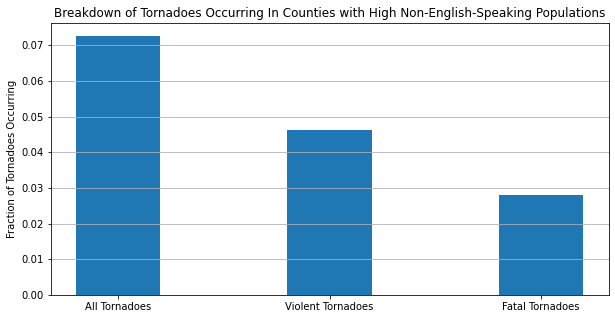

In [102]:
# creating the dataset
data = {'All Tornadoes':p_En, 'Violent Tornadoes':p_strong_En, 
        'Fatal Tornadoes':p_fatal_En}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values,
        width = 0.4)
 
#plt.xlabel("Category")
plt.ylabel("Fraction of Tornadoes Occurring")
plt.title("Breakdown of Tornadoes Occurring In Counties with High Non-English-Speaking Populations")
plt.grid(axis='y')
plt.show()

In [210]:
months = []
cold = []
for i in range(0, len(full_cdc), 1):
    temp = str(int(full_cdc.BEGIN_YEARMONTH.iloc[[i]]))[-2:]
    months.append(temp)

for i in range(0, len(months), 1):
    temp2 = months[i]
    temp2 = int(temp2)
    if temp2==12 or temp2==1 or temp2==2:
        temp3 = 1
    else:
        temp3 = 0
    cold.append(temp3)

full_cdc_cool = full_cdc
full_cdc_cool['Cool'] = cold

In [211]:
cool_season = full_cdc_cool[full_cdc_cool['Cool']==1]

cool_fatal = cool_season[cool_season['DEATHS_DIRECT']>=1]
all_fatal = full_cdc_cool[full_cdc_cool['DEATHS_DIRECT']>=1]

In [223]:
cool_strong = cool_season[cool_season['EF_Rate']>=3]
all_strong = full_cdc_cool[full_cdc_cool['EF_Rate']>=3]

In [230]:
cool_strong_fatal = cool_strong[cool_strong['DEATHS_DIRECT']>=1]
all_strong_fatal = all_strong[all_strong['DEATHS_DIRECT']>=1]

In [212]:
p_cool_season = len(cool_season)/len(full_cdc_cool)
p_cool_season = p_cool_season*100
p_cool_season

12.379028469416518

In [213]:
p_fatal_cool_season = len(cool_fatal)/len(all_fatal)
p_fatal_cool_season = p_fatal_cool_season*100
p_fatal_cool_season

27.055702917771885

In [224]:
p_strong_cool_season = len(cool_strong)/len(all_strong)
p_strong_cool_season = p_strong_cool_season*100
p_strong_cool_season

19.574468085106382

In [214]:
p_all_fatal = len(all_fatal)/len(full_cdc_cool)
p_all_fatal = p_all_fatal*100
p_all_fatal

1.7711171662125342

In [215]:
p_cool_season_fatal = len(cool_fatal)/len(cool_season)
p_cool_season_fatal = p_cool_season_fatal*100
p_cool_season_fatal

3.870967741935484

In [231]:
p_cool_season_strong_fatal = len(cool_strong_fatal)/len(cool_strong)
p_cool_season_strong_fatal = p_cool_season_strong_fatal*100
p_cool_season_strong_fatal

44.20289855072464

In [232]:
p_all_strong_fatal = len(all_strong_fatal)/len(all_strong)
p_all_strong_fatal = p_all_strong_fatal*100
p_all_strong_fatal

33.191489361702125

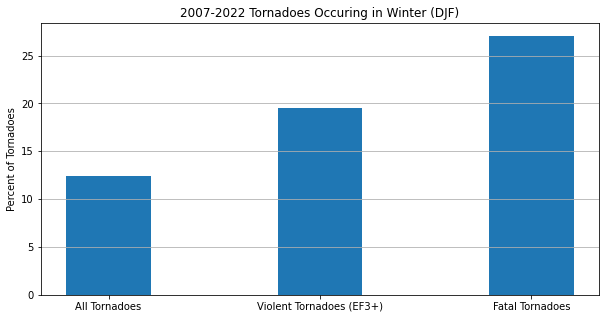

In [228]:
# creating the dataset
data = {'All Tornadoes':p_cool_season, 'Violent Tornadoes (EF3+)':p_strong_cool_season, 
        'Fatal Tornadoes':p_fatal_cool_season}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values,
        width = 0.4)
 
#plt.xlabel("Category")
plt.ylabel("Percent of Tornadoes")
plt.title("2007-2022 Tornadoes Occuring in Winter (DJF)")
plt.grid(axis='y')
plt.show()

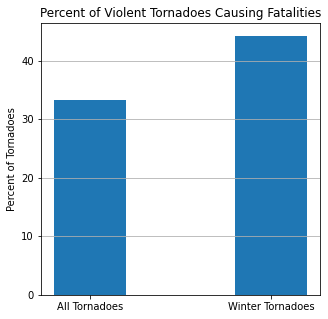

In [233]:
# creating the dataset
data = {'All Tornadoes':p_all_strong_fatal, 'Winter Tornadoes':p_cool_season_strong_fatal}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (5, 5))
 
# creating the bar plot
plt.bar(courses, values,
        width = 0.4)
 
#plt.xlabel("Category")
plt.ylabel("Percent of Tornadoes")
plt.title("Percent of Violent Tornadoes Causing Fatalities")
plt.grid(axis='y')
plt.show()

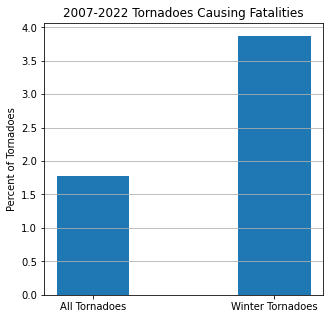

In [615]:
# creating the dataset
data = {'All Tornadoes':p_all_fatal, 'Winter Tornadoes':p_cool_season_fatal}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (5, 5))
 
# creating the bar plot
plt.bar(courses, values,
        width = 0.4)
 
#plt.xlabel("Category")
plt.ylabel("Percent of Tornadoes")
plt.title("2007-2022 Tornadoes Causing Fatalities")
plt.grid(axis='y')
#plt.savefig('Winter_Tors', dpi=150)
plt.show()

In [626]:
print(len(cool_fatal))
print(len(cool_season))

102
2635


In [627]:
mayfield = full_cdc[(full_cdc["BEGIN_YEARMONTH"]==202112) & (full_cdc['BEGIN_DAY']==10)]
mayfield_fatal = mayfield[mayfield['DEATHS_DIRECT']>=1]
print(len(mayfield_fatal))
print(len(mayfield))

14
70


In [ ]:
# fig = plt.figure(figsize = (10, 5))
# fig.subplots(1, 2)

In [103]:
len(full_cdc[full_cdc["DEATHS_DIRECT"]>=1])

377

In [104]:
full_cdc_b = full_cdc[full_cdc["DEATHS_DIRECT"]>=1]
t = len(full_cdc_b)

In [105]:
e0 = len(full_cdc_b[full_cdc_b["EF_Rate"]==0])
e1 = len(full_cdc_b[full_cdc_b["EF_Rate"]==1])
e2 = len(full_cdc_b[full_cdc_b["EF_Rate"]==2])
e3 = len(full_cdc_b[full_cdc_b["EF_Rate"]==3])
e4 = len(full_cdc_b[full_cdc_b["EF_Rate"]==4])
e5 = len(full_cdc_b[full_cdc_b["EF_Rate"]==5])

In [106]:
t0 = len(full_cdc[full_cdc["EF_Rate"]==0])
t1 = len(full_cdc[full_cdc["EF_Rate"]==1])
t2 = len(full_cdc[full_cdc["EF_Rate"]==2])
t3 = len(full_cdc[full_cdc["EF_Rate"]==3])
t4 = len(full_cdc[full_cdc["EF_Rate"]==4])
t5 = len(full_cdc[full_cdc["EF_Rate"]==5])

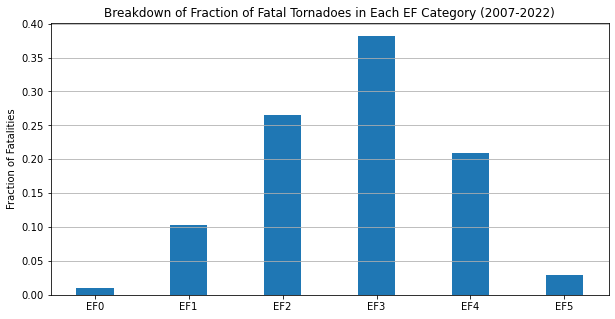

In [229]:
# creating the dataset
data = {'EF0':e0/t, 'EF1':e1/t, 
        'EF2':e2/t, 'EF3':e3/t, 'EF4':e4/t, 
        'EF5':e5/t}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values,
        width = 0.4)
 
#plt.xlabel("Category")
plt.ylabel("Fraction of Fatalities")
plt.title("Breakdown of Fraction of Fatal Tornadoes in Each EF Category (2007-2022)")
plt.grid(axis='y')
plt.show()

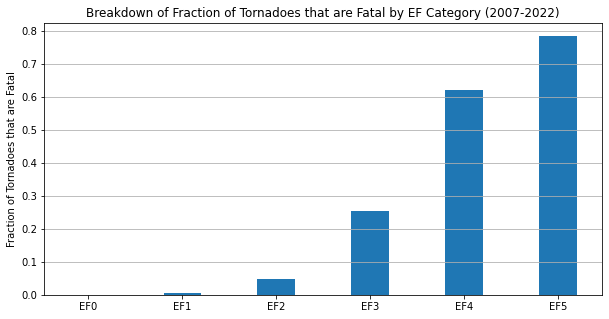

In [108]:
# creating the dataset
data = {'EF0':e0/t0, 'EF1':e1/t1, 
        'EF2':e2/t2, 'EF3':e3/t3, 'EF4':e4/t4, 
        'EF5':e5/t5}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values,
        width = 0.4)
 
#plt.xlabel("Category")
plt.ylabel("Fraction of Tornadoes that are Fatal")
plt.title("Breakdown of Fraction of Tornadoes that are Fatal by EF Category (2007-2022)")
plt.grid(axis='y')
plt.show()

In [109]:
full_cdc_c = full_cdc

full_cdc_c = full_cdc_c[full_cdc_c['E_TOTPOP'].notna()]
full_cdc_c = full_cdc_c[full_cdc_c['E_TOTPOP']!=-999.0]
full_cdc_c = full_cdc_c[full_cdc_c['AREA_SQMI'].notna()]
full_cdc_c = full_cdc_c[full_cdc_c['AREA_SQMI']!=-999.0]

den = []
den = full_cdc_c.E_TOTPOP/full_cdc_c.AREA_SQMI

full_cdc_c['Density']=den

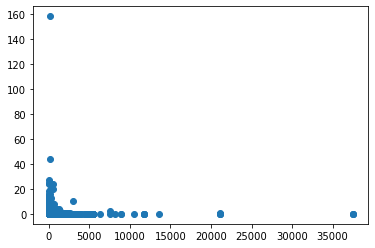

In [110]:
plt.scatter(full_cdc_c.Density, full_cdc_c.DEATHS_DIRECT)

In [111]:
# Compare within high density counties, % of fatal versus in low density counties

In [112]:
high_counties = full_cdc_c[full_cdc_c['Density']>=1000]
low_counties = full_cdc_c[full_cdc_c['Density']<1000]

In [113]:
EF_high = high_counties[high_counties['EF_Rate']==2]
EF_low = low_counties[low_counties['EF_Rate']==2]

In [114]:
EF_high_fatal = EF_high[EF_high['DEATHS_DIRECT']>=1]
EF_low_fatal = EF_low[EF_low['DEATHS_DIRECT']>=1]

In [115]:
EF_high_0 = high_counties[high_counties['EF_Rate']==0]
EF_high_1 = high_counties[high_counties['EF_Rate']==1]
EF_high_2 = high_counties[high_counties['EF_Rate']==2]
EF_high_3 = high_counties[high_counties['EF_Rate']==3]
EF_high_4 = high_counties[high_counties['EF_Rate']==4]
EF_high_5 = high_counties[high_counties['EF_Rate']==5]

EF_low_0 = low_counties[low_counties['EF_Rate']==0]
EF_low_1 = low_counties[low_counties['EF_Rate']==1]
EF_low_2 = low_counties[low_counties['EF_Rate']==2]
EF_low_3 = low_counties[low_counties['EF_Rate']==3]
EF_low_4 = low_counties[low_counties['EF_Rate']==4]
EF_low_5 = low_counties[low_counties['EF_Rate']==5]

In [116]:
EF_high_fatal_0 = EF_high_0[EF_high_0['DEATHS_DIRECT']>=1]
EF_high_fatal_1 = EF_high_1[EF_high_1['DEATHS_DIRECT']>=1]
EF_high_fatal_2 = EF_high_2[EF_high_2['DEATHS_DIRECT']>=1]
EF_high_fatal_3 = EF_high_3[EF_high_3['DEATHS_DIRECT']>=1]
EF_high_fatal_4 = EF_high_4[EF_high_4['DEATHS_DIRECT']>=1]
EF_high_fatal_5 = EF_high_5[EF_high_5['DEATHS_DIRECT']>=1]

EF_low_fatal_0 = EF_low_0[EF_low_0['DEATHS_DIRECT']>=1]
EF_low_fatal_1 = EF_low_1[EF_low_1['DEATHS_DIRECT']>=1]
EF_low_fatal_2 = EF_low_2[EF_low_2['DEATHS_DIRECT']>=1]
EF_low_fatal_3 = EF_low_3[EF_low_3['DEATHS_DIRECT']>=1]
EF_low_fatal_4 = EF_low_4[EF_low_4['DEATHS_DIRECT']>=1]
EF_low_fatal_5 = EF_low_5[EF_low_5['DEATHS_DIRECT']>=1]

In [117]:
p_h_0 = (len(EF_high_fatal_0)/len(EF_high_0))*100
p_h_1 = (len(EF_high_fatal_1)/len(EF_high_1))*100
p_h_2 = (len(EF_high_fatal_2)/len(EF_high_2))*100
p_h_3 = (len(EF_high_fatal_3)/len(EF_high_3))*100
p_h_4 = (len(EF_high_fatal_4)/len(EF_high_4))*100
#p_h_5 = (len(EF_high_fatal_5)/len(EF_high_5))*100
p_h_5 = 0

p_l_0 = (len(EF_low_fatal_0)/len(EF_low_0))*100
p_l_1 = (len(EF_low_fatal_1)/len(EF_low_1))*100
p_l_2 = (len(EF_low_fatal_2)/len(EF_low_2))*100
p_l_3 = (len(EF_low_fatal_3)/len(EF_low_3))*100
p_l_4 = (len(EF_low_fatal_4)/len(EF_low_4))*100
p_l_5 = (len(EF_low_fatal_5)/len(EF_low_5))*100

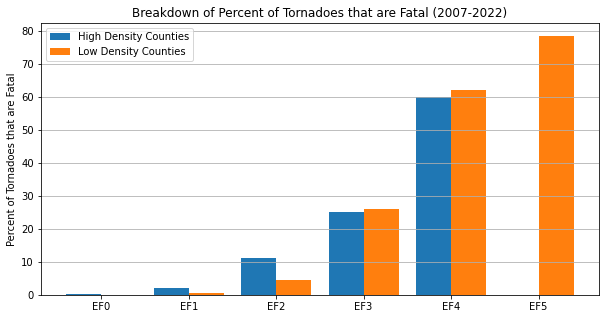

In [118]:
# creating the dataset
data = {'EF0':p_l_0, 'EF1':e1/t1, 
        'EF2':e2/t2, 'EF3':e3/t3, 'EF4':e4/t4, 
        'EF5':e5/t5}
courses = list(data.keys())
values = list(data.values())

cats = ['EF0', 'EF1', 'EF2', 'EF3', 'EF4', 'EF5']
highs = [p_h_0, p_h_1, p_h_2, p_h_3, p_h_4, p_h_5]
lows = [p_l_0, p_l_1, p_l_2, p_l_3, p_l_4, p_l_5]
  
fig = plt.figure(figsize = (10, 5))
X_axis = np.arange(len(cats))

# creating the bar plot
plt.bar(X_axis - 0.2, highs, 0.4, label = 'High Density Counties')
plt.bar(X_axis + 0.2, lows, 0.4, label = 'Low Density Counties')
 
#plt.xlabel("Category")
plt.ylabel("Percent of Tornadoes that are Fatal")
plt.title("Breakdown of Percent of Tornadoes that are Fatal (2007-2022)")
plt.xticks(X_axis, cats)
plt.grid(axis='y')
plt.legend()
plt.show()

In [560]:
day = full_cdc[(full_cdc['BEGIN_TIME']>500) & (full_cdc['BEGIN_TIME']<2200)]
night = full_cdc[(full_cdc['BEGIN_TIME']<=500) | (full_cdc['BEGIN_TIME']>=2200)]

day_fatal = day[day['DEATHS_DIRECT']>=1]
night_fatal = night[night['DEATHS_DIRECT']>=1]

In [561]:
e0_d = len(day_fatal[day_fatal["EF_Rate"]==0])
e1_d = len(day_fatal[day_fatal["EF_Rate"]==1])
e2_d = len(day_fatal[day_fatal["EF_Rate"]==2])
e3_d = len(day_fatal[day_fatal["EF_Rate"]==3])
e4_d = len(day_fatal[day_fatal["EF_Rate"]==4])
e5_d = len(day_fatal[day_fatal["EF_Rate"]==5])

e0_n = len(night_fatal[night_fatal["EF_Rate"]==0])
e1_n = len(night_fatal[night_fatal["EF_Rate"]==1])
e2_n = len(night_fatal[night_fatal["EF_Rate"]==2])
e3_n = len(night_fatal[night_fatal["EF_Rate"]==3])
e4_n = len(night_fatal[night_fatal["EF_Rate"]==4])
e5_n = len(night_fatal[night_fatal["EF_Rate"]==5])

In [562]:
t0_d = len(day[day["EF_Rate"]==0])
t1_d = len(day[day["EF_Rate"]==1])
t2_d = len(day[day["EF_Rate"]==2])
t3_d = len(day[day["EF_Rate"]==3])
t4_d = len(day[day["EF_Rate"]==4])
t5_d = len(day[day["EF_Rate"]==5])

t0_n = len(night[night["EF_Rate"]==0])
t1_n = len(night[night["EF_Rate"]==1])
t2_n = len(night[night["EF_Rate"]==2])
t3_n = len(night[night["EF_Rate"]==3])
t4_n = len(night[night["EF_Rate"]==4])
t5_n = len(night[night["EF_Rate"]==5])

In [563]:
day_0 = (e0_d)/(t0_d)
day_1 = (e1_d)/(t1_d)
day_2 = (e2_d)/(t2_d)
day_3 = (e3_d)/(t3_d)
day_4 = (e4_d)/(t4_d)
day_5 = (e5_d)/(t5_d)

night_0 = (e0_n)/(t0_n)
night_1 = (e1_n)/(t1_n)
night_2 = (e2_n)/(t2_n)
night_3 = (e3_n)/(t3_n)
night_4 = (e4_n)/(t4_n)
#night_5 = (e5_n)/(t5_n)
night_5 = 0

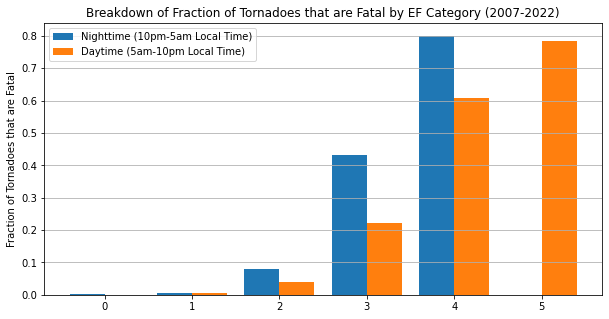

In [564]:
# creating the dataset
cats = ['EF0', 'EF1', 'EF2', 'EF3', 'EF4', 'EF5']
days = [day_0, day_1, day_2, day_3, day_4, day_5]
nights = [night_0, night_1, night_2, night_3, night_4, night_5]
  
fig = plt.figure(figsize = (10, 5))
X_axis = np.arange(len(cats))
 
# creating the bar plot
plt.bar(X_axis - 0.2, nights, 0.4, label = 'Nighttime (10pm-5am Local Time)')
plt.bar(X_axis + 0.2, days, 0.4, label = 'Daytime (5am-10pm Local Time)')
 
#plt.xlabel("Category")
plt.ylabel("Fraction of Tornadoes that are Fatal")
plt.title("Breakdown of Fraction of Tornadoes that are Fatal by EF Category (2007-2022)")
plt.grid(axis='y')
plt.legend()
plt.show()

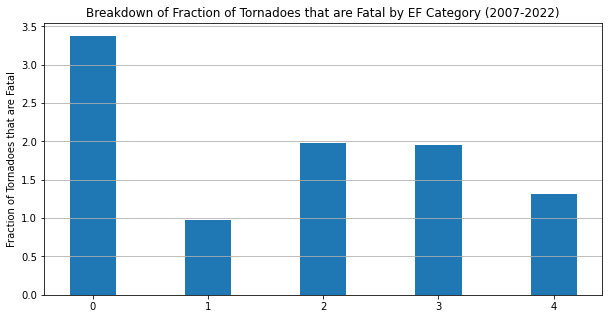

In [574]:
# creating the dataset
cats = ['EF0', 'EF1', 'EF2', 'EF3', 'EF4']
# days = [day_0, day_1, day_2, day_3, day_4, day_5]
# nights = [night_0, night_1, night_2, night_3, night_4, night_5]
dif = [night_0/day_0, night_1/day_1, night_2/day_2, night_3/day_3, night_4/day_4]
  
fig = plt.figure(figsize = (10, 5))
X_axis = np.arange(len(cats))
 
# creating the bar plot
plt.bar(X_axis, dif, 0.4, label = 'Difference')
 
#plt.xlabel("Category")
plt.ylabel("Ratio of Nighttime Fatalities to Daytime Fatalities")
plt.title("Breakdown of Fraction of Tornadoes that are Fatal by EF Category (2007-2022)")
plt.grid(axis='y')
plt.show()

In [119]:
for col in full_cdc.columns:
    print(col)

BEGIN_YEARMONTH
BEGIN_DAY
BEGIN_TIME
END_YEARMONTH
END_DAY
END_TIME
EPISODE_ID
EVENT_ID
STATE_x
STATE_FIPS
YEAR
MONTH_NAME
EVENT_TYPE
CZ_TYPE
CZ_FIPS
CZ_NAME
WFO
BEGIN_DATE_TIME
CZ_TIMEZONE
END_DATE_TIME
INJURIES_DIRECT
INJURIES_INDIRECT
DEATHS_DIRECT
DEATHS_INDIRECT
DAMAGE_PROPERTY
DAMAGE_CROPS
SOURCE
MAGNITUDE
MAGNITUDE_TYPE
FLOOD_CAUSE
CATEGORY
TOR_F_SCALE
TOR_LENGTH
TOR_WIDTH
TOR_OTHER_WFO
TOR_OTHER_CZ_STATE
TOR_OTHER_CZ_FIPS
TOR_OTHER_CZ_NAME
BEGIN_RANGE
BEGIN_AZIMUTH
BEGIN_LOCATION
END_RANGE
END_AZIMUTH
END_LOCATION
BEGIN_LAT
BEGIN_LON
END_LAT
END_LON
EPISODE_NARRATIVE
EVENT_NARRATIVE
DATA_SOURCE
Datetime
EF_Rate
FIPS
ST
STATE_y
ST_ABBR
COUNTY
LOCATION
AREA_SQMI
E_TOTPOP
M_TOTPOP
E_HU
M_HU
E_HH
M_HH
E_POV
M_POV
E_UNEMP
M_UNEMP
E_PCI
M_PCI
E_NOHSDP
M_NOHSDP
E_AGE65
M_AGE65
E_AGE17
M_AGE17
E_DISABL
M_DISABL
E_SNGPNT
M_SNGPNT
E_MINRTY
M_MINRTY
E_LIMENG
M_LIMENG
E_MUNIT
M_MUNIT
E_MOBILE
M_MOBILE
E_CROWD
M_CROWD
E_NOVEH
M_NOVEH
E_GROUPQ
M_GROUPQ
EP_POV
MP_POV
EP_UNEMP
MP_UNEMP
EP_PCI


In [120]:
cdc_test = full_cdc[['RPL_THEMES', 'BEGIN_TIME', 'DEATHS_DIRECT', 'EF_Rate', 'EP_MOBILE']].copy()

In [121]:
cdc_test = cdc_test[cdc_test['RPL_THEMES'].notna()]
cdc_test = cdc_test[cdc_test['RPL_THEMES']!=-999.0]

cdc_test = cdc_test[cdc_test['DEATHS_DIRECT'].notna()]
cdc_test = cdc_test[cdc_test['DEATHS_DIRECT']!=-999.0]

cdc_test = cdc_test[cdc_test['EP_MOBILE'].notna()]
cdc_test = cdc_test[cdc_test['EP_MOBILE']!=-999.0]

In [122]:
fatals = []

for i in cdc_test.DEATHS_DIRECT:
    if i>= 1:
        f = 'Fatal'
    else:
        f= 'Not Fatal'
    fatals.append(f)


cdc_test['Fatalities'] = fatals

In [123]:
cdc_test

,RPL_THEMES,BEGIN_TIME,DEATHS_DIRECT,EF_Rate,EP_MOBILE,Fatalities
0,0.9605,1545,2,1,20.7,Fatal
1,0.8475,1635,0,1,23.8,Not Fatal
2,0.8920,27,0,1,21.9,Not Fatal
3,0.6045,40,0,0,21.3,Not Fatal
4,0.9213,57,0,1,23.1,Not Fatal
...,...,...,...,...,...,...
21280,0.5153,1529,0,0,13.3,Not Fatal
21281,0.3121,940,0,2,7.6,Not Fatal
21283,0.6159,2135,0,1,2.4,Not Fatal
21284,0.4245,2137,0,1,14.7,Not Fatal


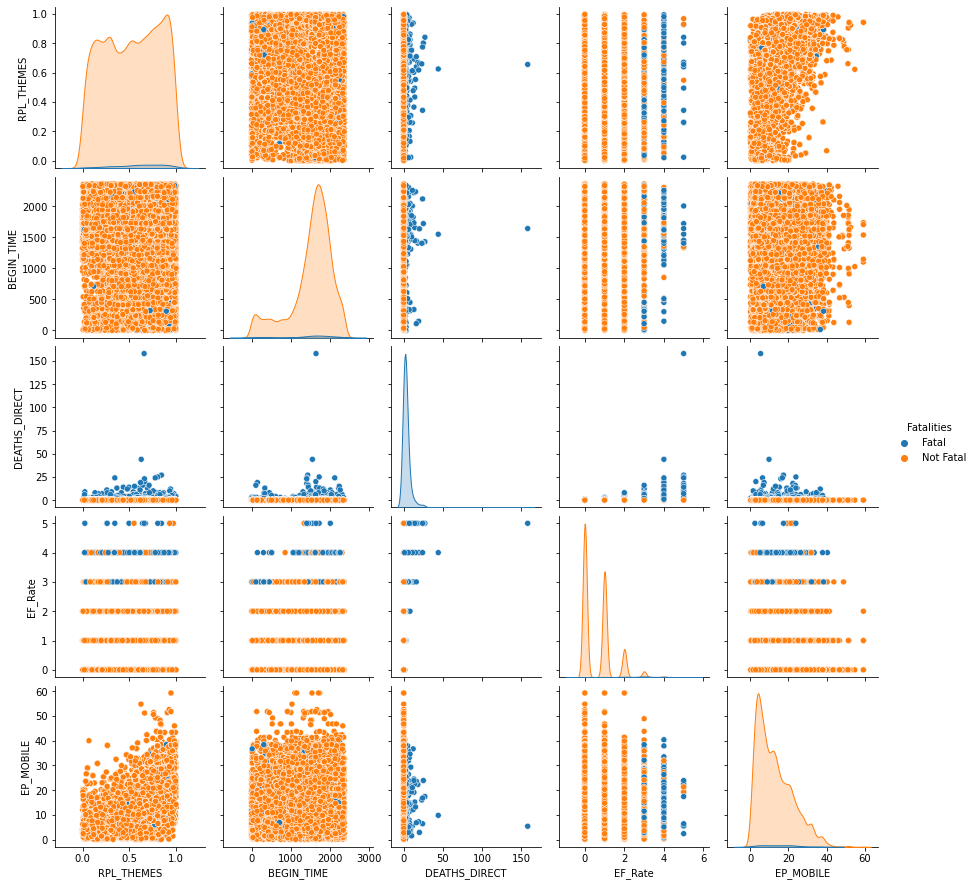

In [124]:
sns.pairplot(cdc_test, hue='Fatalities')

In [125]:
len(cdc_test[cdc_test['DEATHS_DIRECT']==0])/len(cdc_test)

0.9820338304474027

In [126]:
cdc_f = cdc_test[cdc_test['DEATHS_DIRECT']>0]
cdc_nf = cdc_test[cdc_test['DEATHS_DIRECT']==0]

In [127]:
print(cdc_nf['RPL_THEMES'].mean())
print(cdc_f['RPL_THEMES'].mean())

0.5187611731131845
0.6063345403899721


In [128]:
print(cdc_nf['EP_MOBILE'].mean())
print(cdc_f['EP_MOBILE'].mean())

12.746516842480723
15.125626740947071


In [129]:
print(cdc_nf['EF_Rate'].mean())
print(cdc_f['EF_Rate'].mean())

0.6226876624369363
2.777158774373259


In [299]:
# Let's make some maps...

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

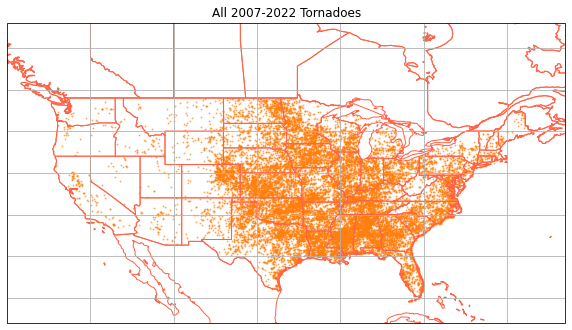

In [507]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

#ax.set_global()

ax.add_feature(cfeature.COASTLINE, edgecolor="tomato")
ax.add_feature(cfeature.BORDERS, edgecolor="tomato")
ax.add_feature(cfeature.STATES, edgecolor="tomato")
ax.gridlines()

ax.set_extent([-130, -63, 22, 58], crs=ccrs.PlateCarree())

plt.scatter(x=full_cdc_cool.BEGIN_LON, y=full_cdc_cool.BEGIN_LAT,
            color="tab:orange",
            s=1,
            alpha=0.5,
            transform=ccrs.PlateCarree())

plt.title('All 2007-2022 Tornadoes')
plt.show()

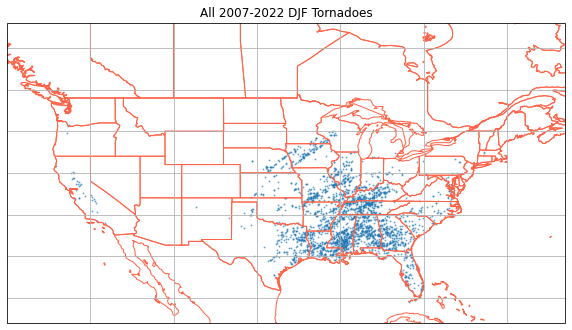

In [508]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

#ax.set_global()

ax.add_feature(cfeature.COASTLINE, edgecolor="tomato")
ax.add_feature(cfeature.BORDERS, edgecolor="tomato")
ax.add_feature(cfeature.STATES, edgecolor="tomato")
ax.gridlines()

ax.set_extent([-130, -63, 22, 58], crs=ccrs.PlateCarree())

plt.scatter(x=cool_season.BEGIN_LON, y=cool_season.BEGIN_LAT,
            color="tab:blue",
            s=1,
            alpha=0.5,
            transform=ccrs.PlateCarree())

plt.title('All 2007-2022 DJF Tornadoes')
plt.show()

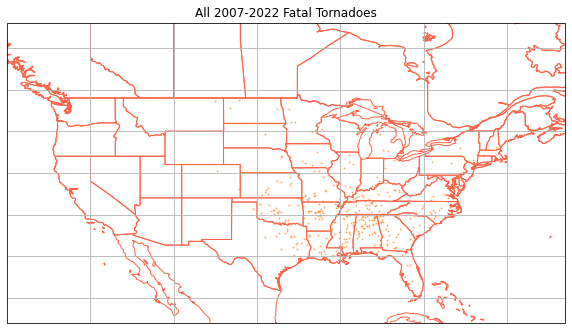

In [509]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

#ax.set_global()

ax.add_feature(cfeature.COASTLINE, edgecolor="tomato")
ax.add_feature(cfeature.BORDERS, edgecolor="tomato")
ax.add_feature(cfeature.STATES, edgecolor="tomato")
ax.gridlines()

ax.set_extent([-130, -63, 22, 58], crs=ccrs.PlateCarree())

plt.scatter(x=all_fatal.BEGIN_LON, y=all_fatal.BEGIN_LAT,
            color="tab:orange",
            s=1,
            alpha=0.5,
            transform=ccrs.PlateCarree())

plt.title('All 2007-2022 Fatal Tornadoes')
plt.show()

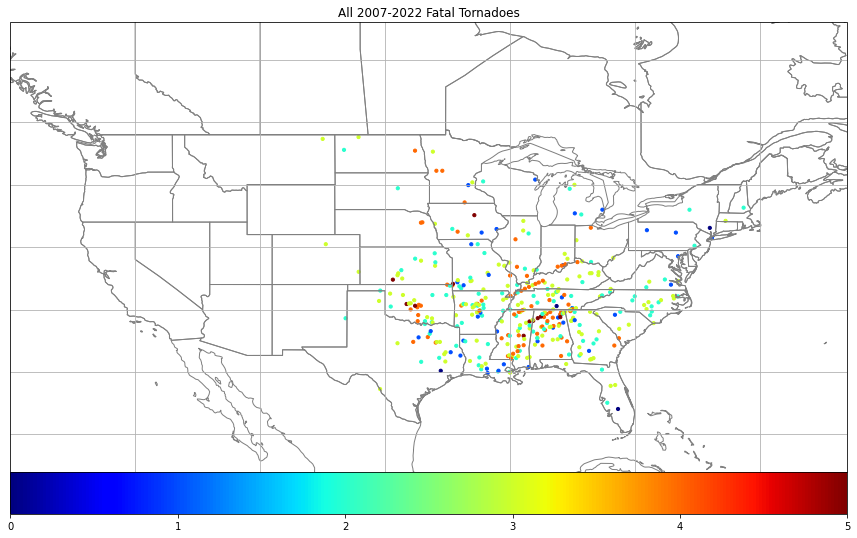

In [610]:
fig = plt.figure(figsize=(15,12))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

#ax.set_global()

ax.add_feature(cfeature.COASTLINE, edgecolor="gray")
ax.add_feature(cfeature.BORDERS, edgecolor="gray")
ax.add_feature(cfeature.STATES, edgecolor="gray")
ax.gridlines()

ax.set_extent([-130, -63, 22, 58], crs=ccrs.PlateCarree())

plt.scatter(x=all_fatal.BEGIN_LON, y=all_fatal.BEGIN_LAT,
            c=all_fatal.EF_Rate,
            cmap='jet',
            s=10,
            alpha=1,
            transform=ccrs.PlateCarree())

plt.colorbar(orientation='horizontal', pad=0)

plt.title('All 2007-2022 Fatal Tornadoes')
plt.show()

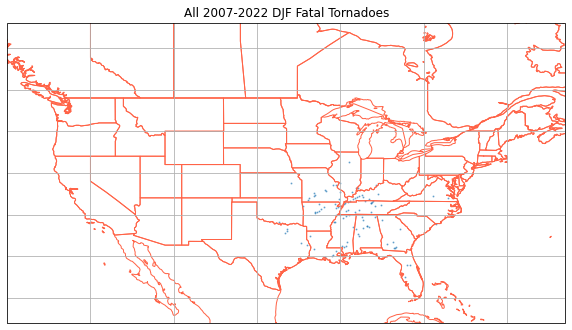

In [510]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

#ax.set_global()

ax.add_feature(cfeature.COASTLINE, edgecolor="tomato")
ax.add_feature(cfeature.BORDERS, edgecolor="tomato")
ax.add_feature(cfeature.STATES, edgecolor="tomato")
ax.gridlines()

ax.set_extent([-130, -63, 22, 58], crs=ccrs.PlateCarree())

plt.scatter(x=cool_fatal.BEGIN_LON, y=cool_fatal.BEGIN_LAT,
            color="tab:blue",
            s=1,
            alpha=0.5,
            transform=ccrs.PlateCarree())

plt.title('All 2007-2022 DJF Fatal Tornadoes')
plt.show()

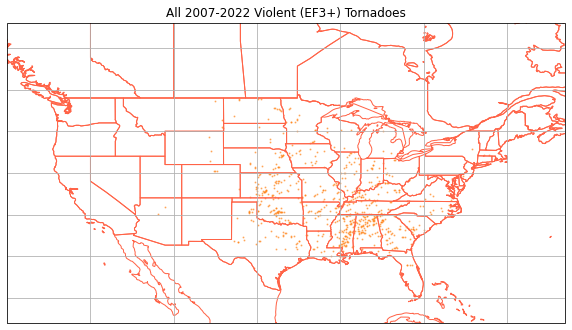

In [609]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

#ax.set_global()

ax.add_feature(cfeature.COASTLINE, edgecolor="tomato")
ax.add_feature(cfeature.BORDERS, edgecolor="tomato")
ax.add_feature(cfeature.STATES, edgecolor="tomato")
ax.gridlines()

ax.set_extent([-130, -63, 22, 58], crs=ccrs.PlateCarree())

plt.scatter(x=all_strong.BEGIN_LON, y=all_strong.BEGIN_LAT,
            color="tab:orange",
            s=1,
            alpha=0.5,
            transform=ccrs.PlateCarree())

plt.title('All 2007-2022 Violent (EF3+) Tornadoes')
plt.show()

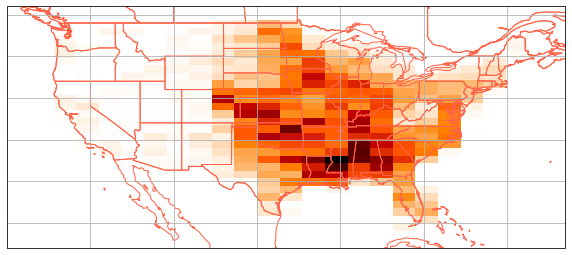

In [270]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt

# Generate some test data
x = full_cdc_cool.BEGIN_LON
y = full_cdc_cool.BEGIN_LAT

heatmap, xedges, yedges = np.histogram2d(x, y, bins=35)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

#ax.set_global()

ax.add_feature(cfeature.COASTLINE, edgecolor="tomato")
ax.add_feature(cfeature.BORDERS, edgecolor="tomato")
ax.add_feature(cfeature.STATES, edgecolor="tomato")
ax.gridlines()

ax.set_extent([-130, -63, 22, 51], crs=ccrs.PlateCarree())

# plt.clf()
ax.imshow(heatmap.T, extent=extent, origin='lower', cmap='gist_heat_r')
plt.show()

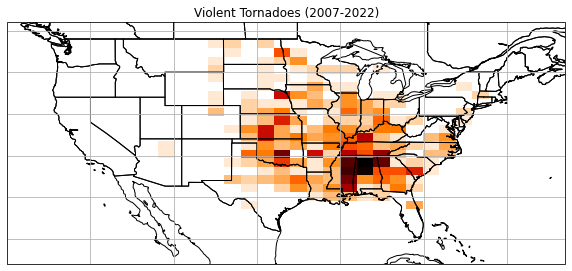

In [323]:
# Generate some test data
x = all_strong.BEGIN_LON
y = all_strong.BEGIN_LAT

heatmap, xedges, yedges = np.histogram2d(x, y, bins=20)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

#ax.set_global()

ax.add_feature(cfeature.COASTLINE, edgecolor="k")
ax.add_feature(cfeature.BORDERS, edgecolor="k")
ax.add_feature(cfeature.STATES, edgecolor="k")
ax.gridlines()

ax.set_extent([-130, -63, 22, 51], crs=ccrs.PlateCarree())

# plt.clf()
ax.imshow(heatmap.T, extent=extent, origin='lower', cmap='gist_heat_r')
plt.title('Violent Tornadoes (2007-2022)')
plt.show()

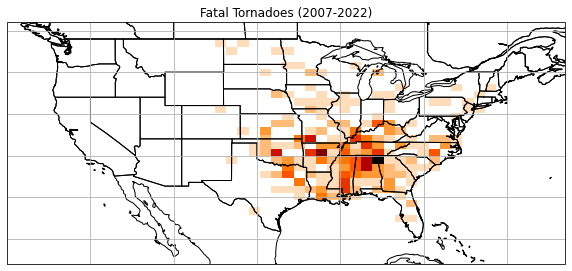

In [297]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

# Generate some test data
x = all_fatal.BEGIN_LON
y = all_fatal.BEGIN_LAT

heatmap, xedges, yedges = np.histogram2d(x, y, bins=25)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

#ax.set_global()

ax.add_feature(cfeature.COASTLINE, edgecolor="k")
ax.add_feature(cfeature.BORDERS, edgecolor="k")
ax.add_feature(cfeature.STATES, edgecolor="k")
ax.gridlines()

ax.set_extent([-130, -63, 22, 51], crs=ccrs.PlateCarree())

# plt.clf()
ax.imshow(heatmap.T, extent=extent, origin='lower', cmap='gist_heat_r')
plt.title('Fatal Tornadoes (2007-2022)')
plt.show()

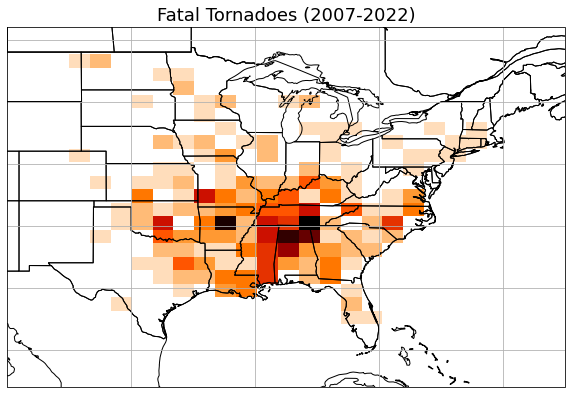

In [326]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

# Generate some test data
x = all_fatal.BEGIN_LON
y = all_fatal.BEGIN_LAT

heatmap, xedges, yedges = np.histogram2d(x, y, bins=20)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

#ax.set_global()

ax.add_feature(cfeature.COASTLINE, edgecolor="k")
ax.add_feature(cfeature.BORDERS, edgecolor="k")
ax.add_feature(cfeature.STATES, edgecolor="k")
ax.gridlines()

ax.set_extent([-110, -65, 22, 51], crs=ccrs.PlateCarree())

# plt.clf()
ax.imshow(heatmap.T, extent=extent, origin='lower', cmap='gist_heat_r')
plt.title('Fatal Tornadoes (2007-2022)', fontsize=18)
plt.show()

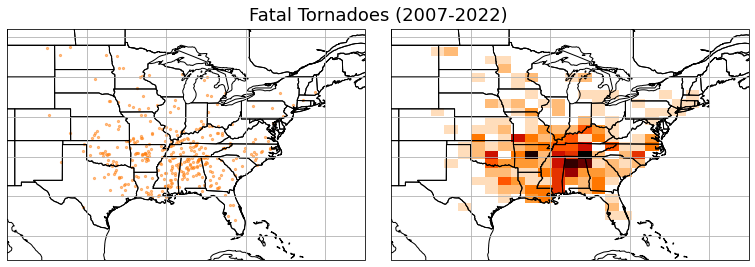

In [319]:
fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(1,2,2, projection=ccrs.PlateCarree())

# Generate some test data
x = all_fatal.BEGIN_LON
y = all_fatal.BEGIN_LAT

heatmap, xedges, yedges = np.histogram2d(x, y, bins=20)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

#ax.set_global()

ax1.add_feature(cfeature.COASTLINE, edgecolor="k")
ax1.add_feature(cfeature.BORDERS, edgecolor="k")
ax1.add_feature(cfeature.STATES, edgecolor="k")
ax1.gridlines()

ax1.set_extent([-110, -65, 22, 51], crs=ccrs.PlateCarree())

# plt.clf()
ax1.imshow(heatmap.T, extent=extent, origin='lower', cmap='gist_heat_r')
#plt.title('Heatmap', fontsize=18)

ax2 = fig.add_subplot(1,2,1, projection=ccrs.PlateCarree())

# Generate some test data
x = all_fatal.BEGIN_LON
y = all_fatal.BEGIN_LAT

# heatmap, xedges, yedges = np.histogram2d(x, y, bins=20)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

#ax.set_global()

ax2.add_feature(cfeature.COASTLINE, edgecolor="k")
ax2.add_feature(cfeature.BORDERS, edgecolor="k")
ax2.add_feature(cfeature.STATES, edgecolor="k")
ax2.gridlines()

ax2.set_extent([-110, -65, 22, 51], crs=ccrs.PlateCarree())

# plt.clf()
plt.scatter(x=all_fatal.BEGIN_LON, y=all_fatal.BEGIN_LAT,
            color="tab:orange",
            s=5,
            alpha=0.5,
            transform=ccrs.PlateCarree())
#plt.title('Reports', fontsize=18)
plt.suptitle('Fatal Tornadoes (2007-2022)', fontsize=18)

fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=-0.2,
                    hspace=0)

plt.show()

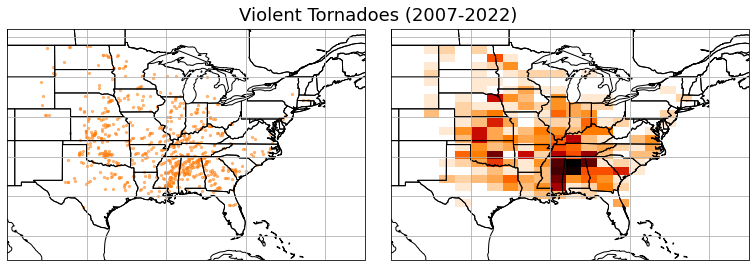

In [328]:
fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(1,2,2, projection=ccrs.PlateCarree())

# Generate some test data
x = all_strong.BEGIN_LON
y = all_strong.BEGIN_LAT

heatmap, xedges, yedges = np.histogram2d(x, y, bins=20)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

#ax.set_global()

ax1.add_feature(cfeature.COASTLINE, edgecolor="k")
ax1.add_feature(cfeature.BORDERS, edgecolor="k")
ax1.add_feature(cfeature.STATES, edgecolor="k")
ax1.gridlines()

ax1.set_extent([-110, -65, 22, 51], crs=ccrs.PlateCarree())

# plt.clf()
ax1.imshow(heatmap.T, extent=extent, origin='lower', cmap='gist_heat_r')
#plt.title('Heatmap', fontsize=18)

ax2 = fig.add_subplot(1,2,1, projection=ccrs.PlateCarree())

ax2.add_feature(cfeature.COASTLINE, edgecolor="k")
ax2.add_feature(cfeature.BORDERS, edgecolor="k")
ax2.add_feature(cfeature.STATES, edgecolor="k")
ax2.gridlines()

ax2.set_extent([-110, -65, 22, 51], crs=ccrs.PlateCarree())

# plt.clf()
plt.scatter(x=all_strong.BEGIN_LON, y=all_strong.BEGIN_LAT,
            color="tab:orange",
            s=5,
            alpha=0.5,
            transform=ccrs.PlateCarree())
#plt.title('Reports', fontsize=18)
plt.suptitle('Violent Tornadoes (2007-2022)', fontsize=18)

fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=-0.2,
                    hspace=0)

plt.show()

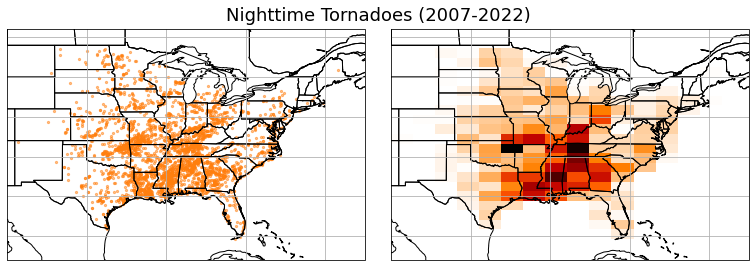

In [329]:
fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(1,2,2, projection=ccrs.PlateCarree())

# Generate some test data
x = idea5.BEGIN_LON
y = idea5.BEGIN_LAT

heatmap, xedges, yedges = np.histogram2d(x, y, bins=20)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

#ax.set_global()

ax1.add_feature(cfeature.COASTLINE, edgecolor="k")
ax1.add_feature(cfeature.BORDERS, edgecolor="k")
ax1.add_feature(cfeature.STATES, edgecolor="k")
ax1.gridlines()

ax1.set_extent([-110, -65, 22, 51], crs=ccrs.PlateCarree())

# plt.clf()
ax1.imshow(heatmap.T, extent=extent, origin='lower', cmap='gist_heat_r')
#plt.title('Heatmap', fontsize=18)

ax2 = fig.add_subplot(1,2,1, projection=ccrs.PlateCarree())

ax2.add_feature(cfeature.COASTLINE, edgecolor="k")
ax2.add_feature(cfeature.BORDERS, edgecolor="k")
ax2.add_feature(cfeature.STATES, edgecolor="k")
ax2.gridlines()

ax2.set_extent([-110, -65, 22, 51], crs=ccrs.PlateCarree())

# plt.clf()
plt.scatter(x=idea5.BEGIN_LON, y=idea5.BEGIN_LAT,
            color="tab:orange",
            s=5,
            alpha=0.5,
            transform=ccrs.PlateCarree())
#plt.title('Reports', fontsize=18)
plt.suptitle('Nighttime Tornadoes (2007-2022)', fontsize=18)

fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=-0.2,
                    hspace=0)

plt.show()

In [330]:
from scipy.stats import chisquare

chisq, p = chisquare(p_fatal_cool_season, p_cool_season)

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
1.1856079404466502

In [607]:
test = full_cdc[(full_cdc['EF_Rate']==0) & full_cdc['DEATHS_DIRECT']>=1]
test

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE_x,STATE_FIPS,...,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP,Cool
6001,201102,28,1223,201102,28,1225,47356,317486,TENNESSEE,47,...,0.0,0.0,0.0,0.0,2906.0,435.0,7.1,1.1,33816.0,1
8797,201206,24,1123,201206,24,1129,63337,379209,FLORIDA,12,...,0.0,0.0,0.0,2.0,12786.0,1122.0,12.7,1.1,99565.0,0
12821,201604,27,343,201604,27,347,103952,633234,TEXAS,48,...,0.0,0.0,2.0,5.0,923767.0,11374.0,20.2,0.2,4075528.0,0
15488,201805,15,1516,201805,15,1517,124185,756478,NEW YORK,36,...,0.0,0.0,0.0,1.0,19347.0,1175.0,5.2,0.3,327925.0,0


In [608]:
test = full_cdc[(full_cdc['EF_Rate']==1) & full_cdc['DEATHS_DIRECT']>=1]
test

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE_x,STATE_FIPS,...,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP,Cool
331,200704,13,1709,200704,13,1715,4322,24686,TEXAS,48,...,0.0,0.0,2.0,4.0,327238.0,6231.0,16.3,0.3,1752032.0,0
1226,200712,15,2120,200712,15,2122,12569,68914,GEORGIA,13,...,0.0,0.0,0.0,3.0,1145.0,342.0,15.0,4.5,6987.0,1
1340,200801,29,1958,200801,29,1959,13053,72219,INDIANA,18,...,0.0,0.0,0.0,0.0,9723.0,969.0,8.5,0.9,108571.0,1
1474,200802,12,1345,200802,12,1347,14804,84000,LOUISIANA,22,...,0.0,0.0,0.0,0.0,14494.0,1330.0,11.2,1.0,122481.0,1
1527,200802,26,342,200802,26,345,14399,85237,ALABAMA,1,...,0.0,0.0,1.0,1.0,62164.0,2585.0,9.5,0.4,673990.0,1
2043,200805,10,1708,200805,10,1713,17141,99255,MISSOURI,29,...,0.0,0.0,0.0,0.0,15411.0,1307.0,13.0,1.1,126422.0,0
2622,200806,8,1445,200806,8,1456,19086,116822,MICHIGAN,26,...,0.0,0.0,1.0,1.0,5836.0,643.0,5.4,0.6,96547.0,0
3564,200904,19,1935,200904,19,1939,26489,159800,ALABAMA,1,...,0.0,0.0,0.0,0.0,12367.0,941.0,13.1,1.0,91060.0,0
3786,200905,13,1610,200905,13,1635,28828,171718,MISSOURI,29,...,0.0,0.0,0.0,1.0,894.0,186.0,14.6,3.0,5855.0,0
4344,200910,9,1045,200910,9,1048,33953,197132,MISSISSIPPI,28,...,1.0,0.0,1.0,6.0,8506.0,645.0,18.2,1.4,45511.0,0
